# Исследование объявлений о продаже квартир

Это учебный проект, выполненный в ходе обучения.

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Перед нами поставлены следующие задачи:
- Подготовить данные к анализу
  - Избавиться от пропусков, где это возможно.
  - Избавиться от дубликатов.
  - Избавиться от аномальных значений.
  - Преобразовать данные в необходимый формат там, где это требуется.
- Провести исследовательский анализ
  - Изучить отдельные параметры объектов
  - Изучить скорость продажи недвижимости, определить сколько времени она обычно занимает, и когда её можно считать быстрой, а когда долгой
  - Определить от каких параметров больше всего зависит конечная стоимость жилья.
  - Посчитать среднюю цену квадратного метра в 10 населённых пунктах с максимальным кол-вом объявлений.
  - Вычислить среднюю стоимость жилья на разном удалении от центра в Санкт-Петербурге.
 
Результаты исследования помогут построить автоматизированную систему, отслеживающую аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Ознакомление с датасетом

In [1]:
import pandas as pd # Импорт необходимых библиотек
from IPython.display import display

In [2]:
ds = pd.read_csv('real_estate_data.csv', sep='\t') # Открытие файла
pd.set_option('display.max_columns', None) # Снятие ограничения на выводимое кол-во столбцов

In [3]:
def dataset_info(ds):
    print('Общая информация о датасете')
    display(ds.head())
    print(f'Количество дубликатов: {ds.duplicated().sum()}\n')
    ds.info()
    ds.hist(bins=18, figsize=(20,25));

Общая информация о датасете


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object

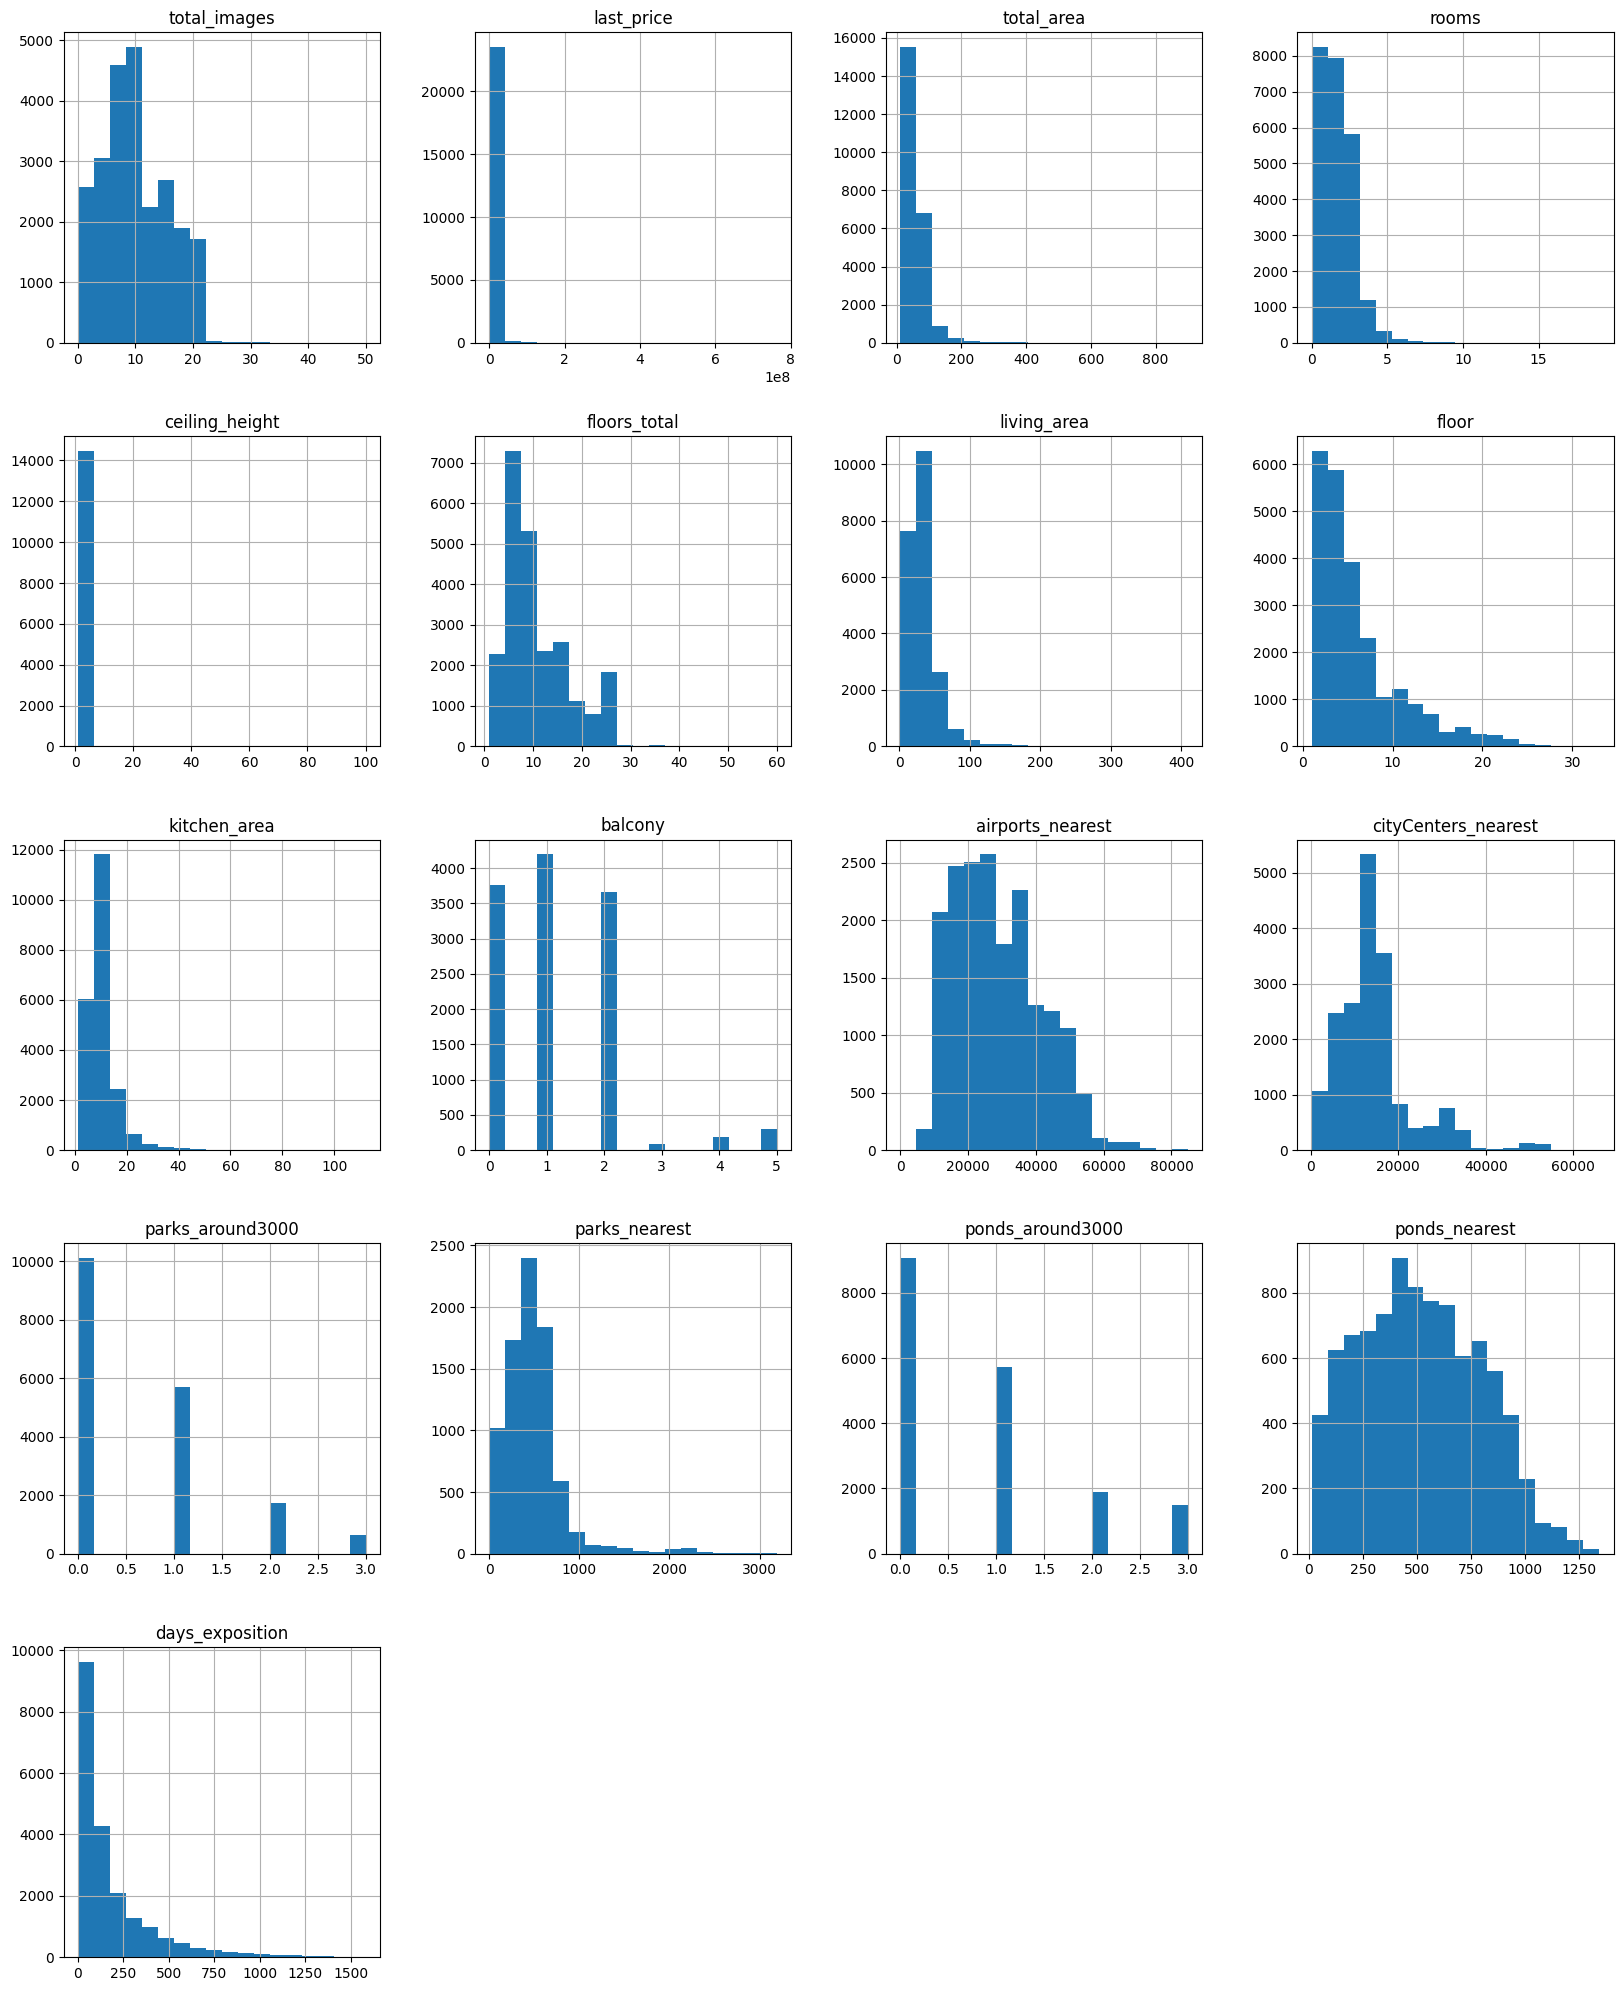

In [4]:
dataset_info(ds)

Все данные склеились в один большой столбец. Чтобы этого избежать - добавляем разделитель данных при чтении файла, в этом случае - '\t'

Гистограмма last_price, с ценой на момент снятия с публикации, выглядит подозрительно. Пик на нуле, максимальное значение не превышает восьми. Вернёмся к этому на моменте предобработки.

Также гистограмма ceiling_height, с высотой потолков в метрах, показывает значения вплоть до 100 метров, что тоже выглядит подозрительно.

Все остальные графики показывают ожидаемый результат.

## Предобработка данных

### Работа с пропусками

Сперва займёмся пропусками. Посчитаем общее их количество в каждом столбце

In [5]:
ds.isna().sum() # Количество пропусков в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Начнём с высоты потолков, количества этажей и жилой площади. Едва-ли квартира может обойтись без всего этого, потому заполним пропуски медианными значениями

In [6]:
for column in ['ceiling_height', 'floors_total']: # Заполнение медианными значениями списка столбцов
    ds[column] = ds[column].fillna(ds[column].median())

In [7]:
ds.loc[ds['floors_total']<ds['floor'], 'floors_total'] = ds['floor'] # Если в результате замены дом стал ниже этажа самой квартиры - поднимаем дом, делая квартиру последним этажом

In [8]:
ds.loc[ds['living_area'].isna(), 'living_area'] = ((ds['living_area']/ds['total_area']).mean()*ds.loc[ds['living_area'].isna(), 'total_area']).round(1)
# Считаем среднее соотношение между жилой площадью и общей, и заполняем пропущенные значения общей площадью, умноженной на коэффициент 

Очень много пропусков в столбце is_apartment. Проверим осталось-ли в столбце что-то кроме них

In [9]:
ds['is_apartment'].value_counts() # уникальные значения столбца is_apartment

False    2725
True       50
Name: is_apartment, dtype: int64

Судя по всему, заполнение этой информации на сайте не обязательно, и те, чьи квартиры апартаментами не являются, просто пропускали этот пункт. Заполним его за них.

In [10]:
ds['is_apartment'] = ds['is_apartment'].fillna(False)

Далее - площадь кухни. Это могут быть квартиры-студии, или просто квартиры без кухонь. Проверим.

In [11]:
len(ds.query('kitchen_area.isna() == True and studio == True'))

149

149 студий, и все без кухни. Но до двух тысяч пропусков не дотягивает. Заполним пропуски нулями, у них нет отдельных кухонь

In [12]:
ds.loc[ds['studio'] == True, 'kitchen_area'] = ds['kitchen_area'].fillna(0) # Заполнение пропусков в площади кухонь у студий нулями

In [13]:
ds.query('kitchen_area.isna() == True').loc[:,['kitchen_area','total_area','living_area']]

,kitchen_area,total_area,living_area
3,NaN,159.0,89.8
30,NaN,32.8,18.5
37,NaN,45.8,25.9
44,NaN,40.0,22.6
59,NaN,46.5,26.3
...,...,...,...
23655,NaN,40.5,19.6
23663,NaN,88.0,49.7
23670,NaN,45.6,25.8
23679,NaN,35.0,19.8


Вот и оставшиеся проблемные записи. Это может быть как ошибка при выгрузке, так и не заполненные пользователем значения. Посчитаем что в квартирах, где разница между общей площадью и жилой площадью менее 5 квадратных метров, нет кухонь. Остальные пропуски заполним средним соотношением площади кухни к общей площади помещения.

In [14]:
ds.loc[ds['kitchen_area'].isna(), ['kitchen_area', 'total_area']].head() # Выборка для проверки работы заполнения

,kitchen_area,total_area
3,NaN,159.0
30,NaN,32.8
37,NaN,45.8
44,NaN,40.0
59,NaN,46.5


In [15]:
ds.loc[ds['total_area'] - ds['living_area'] < 5, 'kitchen_area'] = ds['kitchen_area'].fillna(0) # Заполнение пропусков нулями и медианой соответственно
ds.loc[ds['kitchen_area'].isna(),'kitchen_area'] = ((ds['kitchen_area']/ds['total_area']).mean()*ds.loc[ds['kitchen_area'].isna(), 'total_area']).round(1)

In [16]:
ds.loc[[3,30,37,44,59],['kitchen_area', 'total_area']] # Проверяем что все записи в выборке рассчитаны верно

,kitchen_area,total_area
3,29.5,159.0
30,6.1,32.8
37,8.5,45.8
44,7.4,40.0
59,8.6,46.5


Далее - балконы. Разумно предположить, что если у квартиры нет балконов, владелец не станет заполнять информацию о них, поэтому пропуски заполним нулями.

In [17]:
ds['balcony'] = ds['balcony'].fillna(0)

Остаются только пропуски в `days_exposition`, количество дней от публикации до снятия. Скорее всего квартиры, где пропущено это значение, так и не были проданы, поэтому пропуски лучше будет оставить.

Посмотрим на пропуски ещё раз, чтобы убедиться что всё, что можно заменить, было заменено.

In [18]:
ds.isna().sum() # Количество пропусков в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропусков в данных о расстоянии до парков, прудов, центра города и т.д слишком много для того чтобы заполнять их медианным значением, иначе данные сильно исказятся. Придётся оставить их нетронутыми, и работать с тем, что имеем.

**Промежуточный вывод**: Пропуски в данных носят разный характер, от не указанного количества балконов, до программного сбоя при автоматическом заполнении расстояния до ближайшего парка. В целом, было-бы неплохо разобраться в причине возникновения пропусков в автоматически заполняемых данных, а так-же убедиться, что заполняемые пользователем данные являются обязательными к заполнению, или имеют базовое значение(Например, если пользователь не выбрал количество балконов, их количество будет записано как 0)

### Работа с типами данных

In [19]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Дата выставления на продажу сохранилась в виде строки, переведём в формат datetime для более удобного доступа к данным

In [20]:
ds['first_day_exposition'] = pd.to_datetime(ds['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # Переводим столбец с датой в формат datetime

Столбцы с количеством балконов и общим количеством этажей из-за наличия пропусков считались типом float, хотя содержат только целые числа. Вернём им целочисленный тип данных.

In [21]:
for column in ['balcony', 'floors_total']:
    ds[column] = ds[column].astype('int')

Все данные с плавающей точкой float64 заменим на float32 для экономии места

In [22]:
for column in ds:
    if ds[column].dtypes=='float64':
        ds[column] = ds[column].astype('float32')

In [23]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float32       
 2   total_area            23699 non-null  float32       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float32       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float32       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float32       
 13  balcony         

**Промежуточный вывод**: Мы преобразовали дату и время из строки в соответствующий тип данных, вернули столбцам с количеством балконов и количеством этажей целочисленный тип данных, а также преобразовали тип float64 в более лёгкий, но достаточно гибкий для наших нужд тип float32

### Работа с дубликатами

Явных дубликатов в данных нет, это мы выяснили при ознакомлении с данными. Пройдёмся по менее явным.

In [24]:
ds['locality_name'].value_counts() # Подсчёт уникальных значений столбца с названиями поселений

Санкт-Петербург       15721
посёлок Мурино          522
посёлок Шушары          440
Всеволожск              398
Пушкин                  369
                      ...  
деревня Новолисино        1
поселок Пчевжа            1
деревня Нижняя            1
деревня Пижма             1
поселок Лисий Нос         1
Name: locality_name, Length: 364, dtype: int64

К названиям добавлены ещё и типы поселений - село, деревня и т.д. Уберём их, попутно приведя всё к нижнему регистру

In [25]:
ds['locality_name'] = ds['locality_name'].str.lower().str.replace('ё','е').replace(['поселок','село','деревня', 'садовое товарищество', 'при железнодорожной станции', 'городской'], '', regex=True).str.strip()
ds['locality_name'].value_counts()

санкт-петербург        15721
мурино                   590
кудрово                  472
шушары                   440
всеволожск               398
                       ...  
коттеджный  счастье        1
терпилицы                  1
раздолье                   1
шпаньково                  1
красносельское             1
Name: locality_name, Length: 319, dtype: int64

Было 45 дублированных названий, теперь их нет.

**Промежуточный вывод**: Мы устранили разницу в написании названий населённых пунктов. Из-за неё на этапе исследования могли-бы возникнуть проблемы с группировкой данных. В целом было удалено 45 дубликатов-названий населённых пунктов.

### Работа с аномалиями

Сперва посмотрим на более подробную гистограмму цен, при ознакомлении с данными она показала странный результат

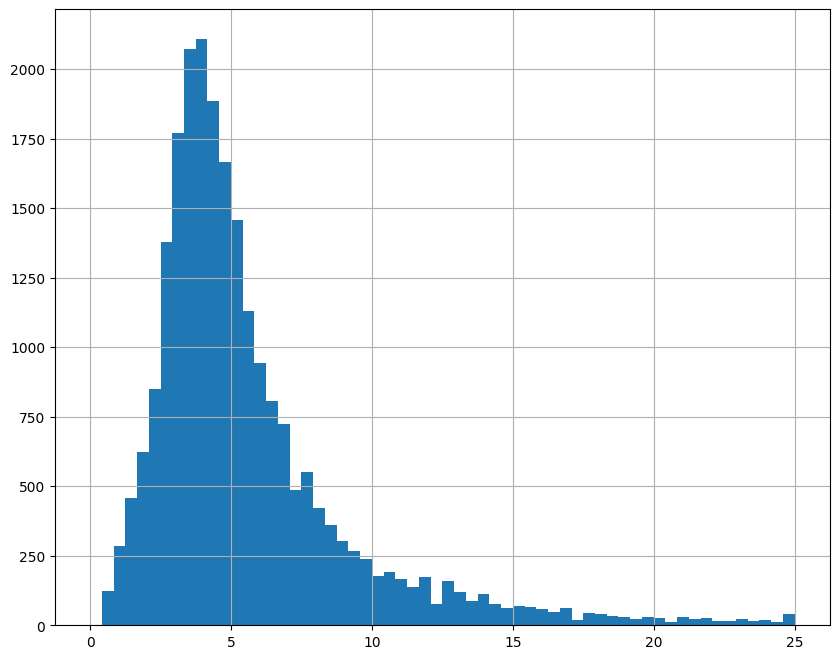

In [26]:
(ds['last_price']/1000000).hist(bins= 60, figsize =(10, 8), range=(0, 25)); # Гистограмма цен от 0 до 25 миллионов

Нет, всё нормально, и распределение значений соответствует ожидаемому, виден явный пик на 3-5 миллионах, что похоже на правду. 
Странный вид гистограммы был связан с малым масштабом.

Также взглянем поближе на высоту потолков. Значения близкие к сотне кажутся неправдоподобными.

In [27]:
ds['ceiling_height'].describe().round(3) # Общее описание данных столбца

count    23699.000
mean         2.724
std          0.988
min          1.000
25%          2.600
50%          2.650
75%          2.700
max        100.000
Name: ceiling_height, dtype: float64

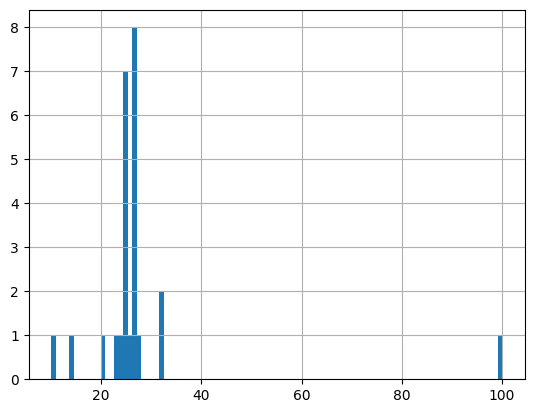

In [28]:
ds['ceiling_height'].hist(range=(10, 100), bins=100); # Гистограмма высоты потолков от 10 до 100 метров

Всего одно значение, зато какое. Также присутствует больше десятка потолков высотой больше 20 метров, что скорее всего является ошибкой ввода вещественных чисел. Значения от 10 до 40 поделим на 10, а аномальное значение 100 заменим медианой

In [29]:
ds.loc[ds['ceiling_height']>60, 'ceiling_height'] = ds['ceiling_height'].median()
ds.loc[(ds['ceiling_height']>10) & (ds['ceiling_height']<60), 'ceiling_height'] = ds['ceiling_height']/10
ds['ceiling_height'].mean().round(3) # Среднее значение высоты потолков

2.697

Среднее значение после этого поменялось на одну десятую метра. Видно, что аномально высокие значения влияли на него.

**Промежуточный вывод**: Подозрительные значения в цене, на которые мы обратили внимание в самом начале, оказались лишь результатом малого масштаба графика. Зато мы обнаружили и заменили на более реалистичные значения показатели высоты потолков.

## Добавление новых столбцов

In [30]:
ds['square_price'] = (ds['last_price']/ds['total_area']).round(2) # Цена за один квадратный метр

In [31]:
ds['dow'] = ds['first_day_exposition'].dt.dayofweek # day of week/день недели публикации

In [32]:
ds['month'] = ds['first_day_exposition'].dt.month # Месяц публикации

In [33]:
ds['year'] = ds['first_day_exposition'].dt.year # Год публикации

In [34]:
ds.loc[ds['floor'] == ds['floors_total'], 'floor_type'] = 'последний' # Распределение категорий по этажам
ds.loc[ds['floor'] == 1, 'floor_type'] = 'первый'
ds.loc[(ds['floor'] != 1) & (ds['floor'] != ds['floors_total']), 'floor_type'] = 'другой'

In [35]:
ds['city_centre_km'] = (ds['cityCenters_nearest']/1000).round(0) # Перевод расстояния до центра из метров в километры

In [36]:
ds.head() # Проверяем что всё на месте

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_price,dow,month,year,floor_type,city_centre_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.367188,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.0,2,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.789062,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.710938,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.800003,9,False,False,False,29.5,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.093750,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0


**Промежуточный вывод**: Мы добавили несколько новых столбцов с преобразованными данными, которые пригодится в разделе анализа. Среди них цена за квадратный метр, день недели, месяц и год выставления объявления, категория этажа(Первый/Последний/Другой) и расстояние до центра города в километрах.

## Исследовательский анализ данных

### Изучение отдельных параметров

Начнём с построения подробных гистограмм и удаления аномальных значений. Пройдёмся последовательно по следующим параметрам:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

In [37]:
def hist_maker(data, column, range_a=0, range_b=200, bins=30): # Функция для быстрого построения гистограмм
    data[column].plot(kind = 'hist', bins=bins, grid=True, range=(range_a, range_b))

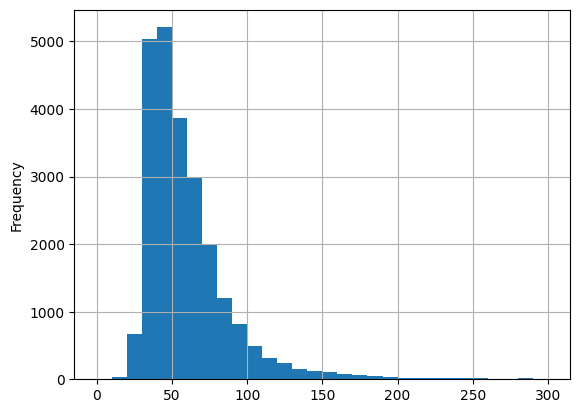

In [38]:
hist_maker(ds, 'total_area', 0, 300) # Общая площадь, квадратных метров

Распределение соответствует норме, редкие значения выше 200 квадратных метров явно являются аномалией, лучше будет от них избавиться.

In [39]:
ds = ds[ds['total_area']<=200]

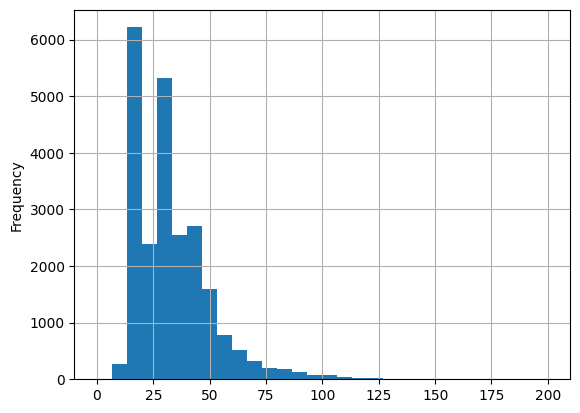

In [40]:
hist_maker(ds, 'living_area') # Жилая площадь, квадратных метров

2 пика и резкий провал в районе 20 квадратных метров. Учитывая специфику данных, это может быть особенностью популярных планировок. Значения выше 125 встречаются крайне редко, уберём лишнее.

In [41]:
ds = ds[ds['living_area']<=125]

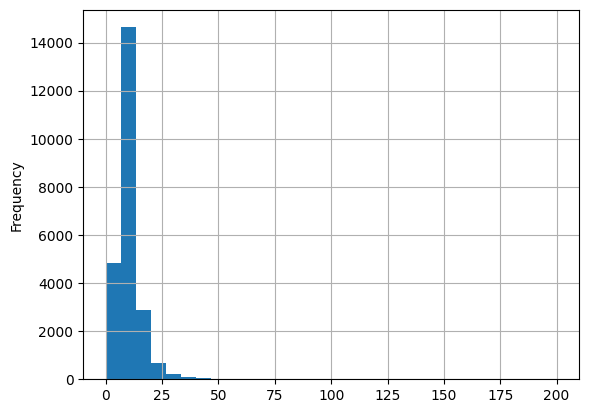

In [42]:
hist_maker(ds, 'kitchen_area') # Площадь кухни, квадратных метров

Выглядит правдоподобно, кухне не нужно слишком много места

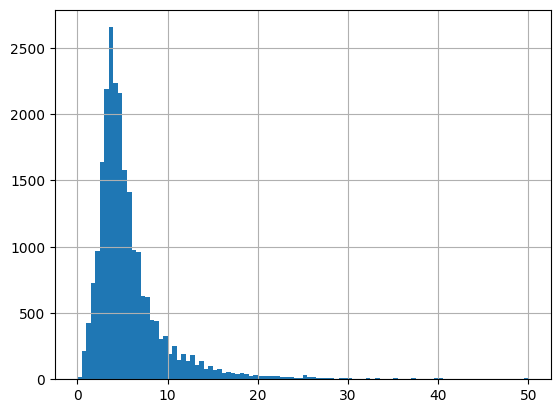

In [43]:
(ds['last_price']/1000000).hist( range=(0, 50), bins=100); # Цена, миллионов

Абсолютное большинство квартир стоят около 5 миллионов. Значения выше 25 можно назвать аномалией.

In [44]:
ds = ds[ds['last_price']<=25000000] # Удаляем из датасета записи с ценой более 25 миллионов

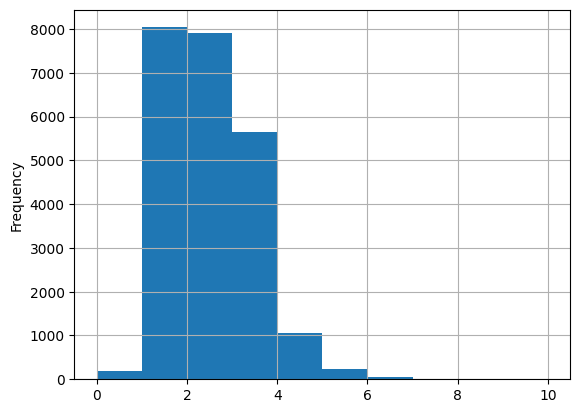

In [45]:
hist_maker(ds, 'rooms', 0, 10, 10) # Количество комнат

От одной до трёх комнат - самое популярное решение. 

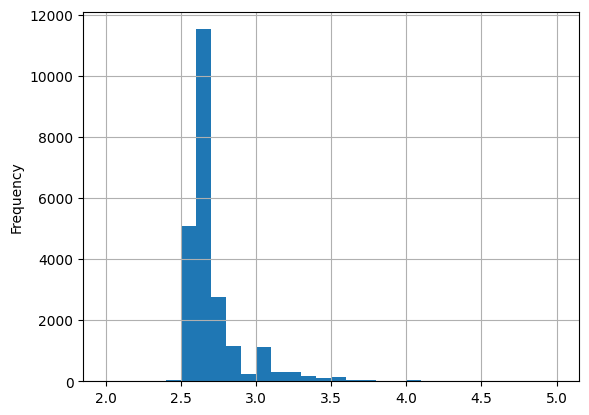

In [46]:
hist_maker(ds, 'ceiling_height', 2, 5) # Высота потолков, метров

С высотой потолков мы уже разобрались на этапе предобработки. Значения от двух с половиной до трёх метров - самые популярные.

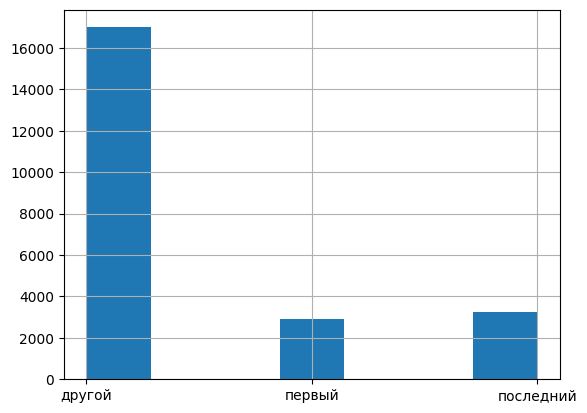

In [47]:
ds['floor_type'].hist(bins=7); # Тип этажа квартиры

Как и ожидалось, квартир на других этажах больше, чем на первых или последних. Но квартир на последних этажах немного больше, чем на первых. Почему-то их продают чаще.

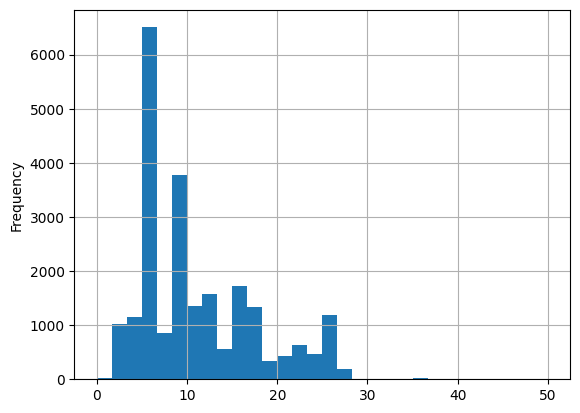

In [48]:
hist_maker(ds, 'floors_total', 0, 50) # Общее количество этажей в доме

Видны два главных пика. Очень популярные в нашей стране пятиэтажки и девятиэтажки дают о себе знать. Посмотрим также на самые высокие здания в данных.

In [49]:
ds.loc[:,['last_price', 'floors_total', 'floor', 'locality_name']].sort_values(by = 'floors_total', ascending=False).head()

,last_price,floors_total,floor,locality_name
2253,3800000.0,60,4,кронштадт
16731,3978000.0,52,18,санкт-петербург
16934,4100000.0,37,5,санкт-петербург
11079,9200000.0,36,29,санкт-петербург
5807,8150000.0,36,13,санкт-петербург


60 этажей - это многовато. Особенно для городка-порта на острове, как и 52, если, конечно, не жить в ещё недостроенном на момент 2018 года Лахта-Центре. Да и цена подозрительно низкая для жилья в столь массивном сооружении. Пожалуй, уберём эти 2 аномальные записи во избежание искажений.

In [50]:
ds = ds[ds['floors_total']<50]

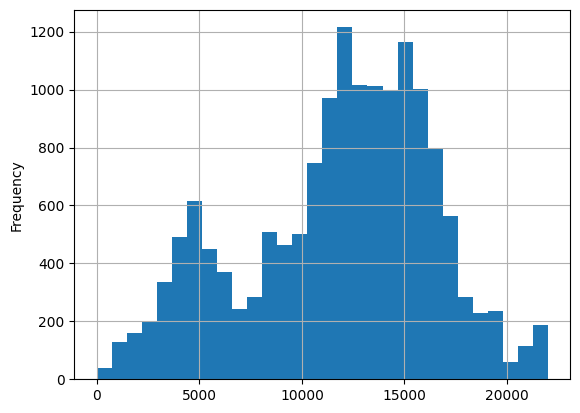

In [51]:
hist_maker(ds, 'cityCenters_nearest', 0, 22000, 30) # Расстояние до ближайшего центра города, метров

Записей со значением около 7500 немного меньше, виден явный спад. Возможно это связано со спецификой застройки, где основные жилые районы находятся около центра, а жилые массивы на удалении. Как-бы то ни было, на удалении от центра квартиры продают гораздо чаще.

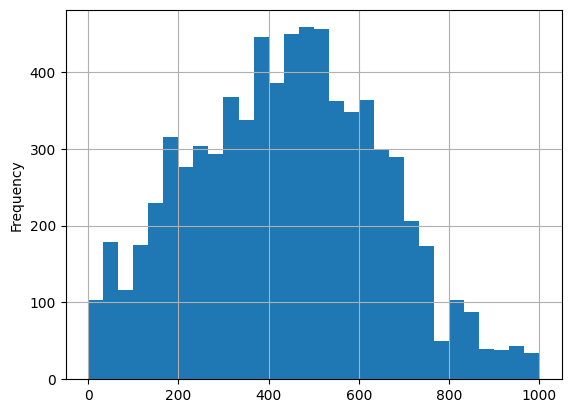

In [52]:
hist_maker(ds, 'parks_nearest', 0, 1000, 30) # Расстояние до ближайшего парка, метров

Парков много, и это хорошо. Распределение соответствует нормальному, и это ещё лучше. График показал ожидаемый результат, чаще всего парки находятся на расстоянии от 300 до 600 метров.

**Промежуточный вывод**: Почти все значения показали ожидаемые результаты в пределах нормы. А редкие аномалии были удалены.

### Изучение скорости продажи квартир

Теперь мы построим гистограмму столбца `days_exposition`, который содержит информацию о количестве дней, которые объявление провело на публикации, посчитаем среднюю и медианную скорость продажи и определим сколько времени обычно занимает продажа квартиры, какие продажи можно считать быстрыми, а какие долгими. Но всё по порядку.

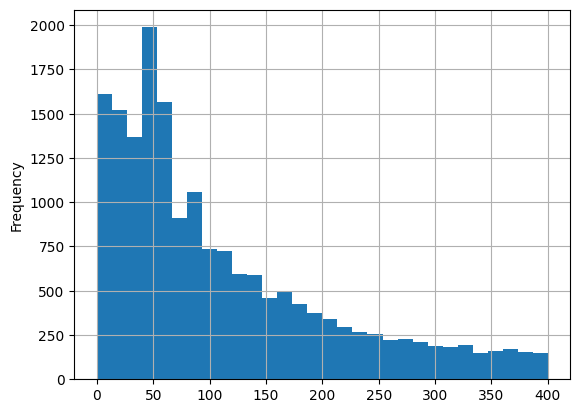

In [53]:
hist_maker(ds, 'days_exposition', 0, 400, 30) # Количество дней, проведённых в продаже

Судя по графику, большая часть квартир продаётся сравнительно быстро. У некоторых это даже занимает не более нескольких дней.

In [54]:
ds['days_exposition'].describe() # общая информация о содержащихся данных

count    20105.000000
mean       178.458298
std        217.067978
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее значение больше медианы почти в 2 раза. На него сильно влияют высокие значения.

Взглянем на диапазон нормальных значений, для этого построим диаграмму размаха.

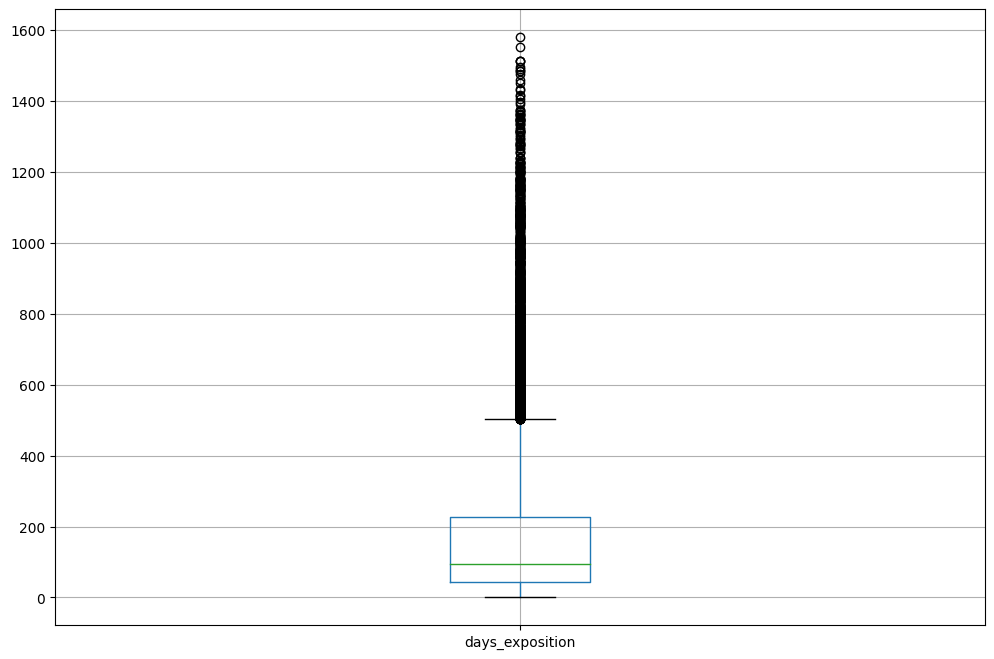

In [55]:
ds.boxplot('days_exposition', figsize=(12,8)); # Построение диаграммы размаха для столбца с количеством дней

Нижний 'ус' упирается в нулевые значения. В данных очень много записей с быстро проданным жильём.

**Промежуточный вывод**: В среднем, квартира продаётся от 45 до 230 дней. При этом продажи за менее чем 45 дней можно считать быстрыми, а продажи от 230 до 500 дней долгими. Продажи, длящиеся более 500 дней встречаются гораздо реже, но тем не менее встречаются, и их можно считать чрезвычайно долгими.

### Анализ влияния различных факторов на цену объекта

Теперь мы проверим зависимость между итоговой стоимостью объекта недвижимости и:
- общей площадью;
- жилой площадью;
- площадью кухни;
- количеством комнат;
- этажом, на котором расположена квартира (первый, последний, другой);
- датой размещения (день недели, месяц, год).

Проще всего будет построить сводную таблицу и рассчитать коэффициенты корреляции для каждой пары значений

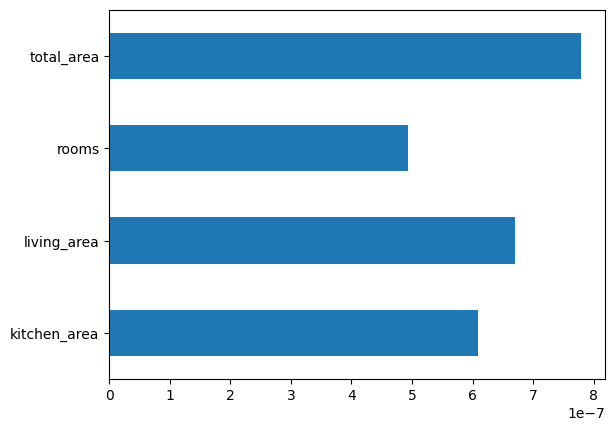

In [56]:
price_pivot = ds.pivot_table(index=ds.index, values=['total_area', 'living_area', 'kitchen_area', 'rooms'])
(price_pivot.corrwith(ds['last_price'])/1000000).plot(kind='barh'); # Коэффициент корреляции по отношению к цене, миллионов

Теперь построим графики для оценки нелинейной зависимости от оставшихся параметров.

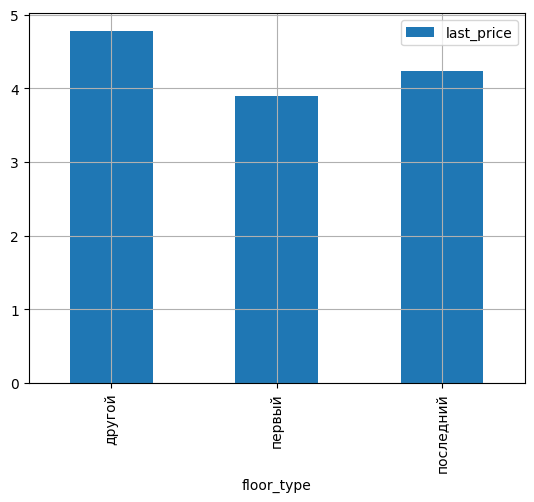

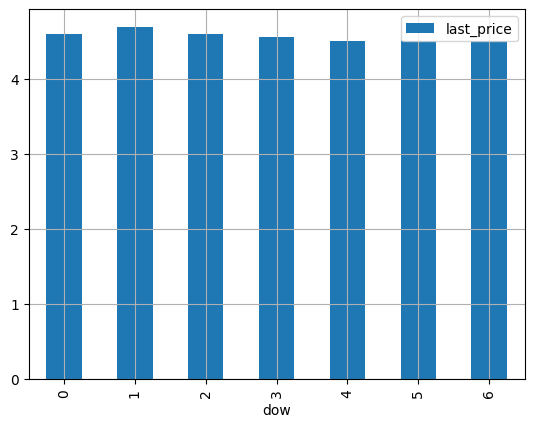

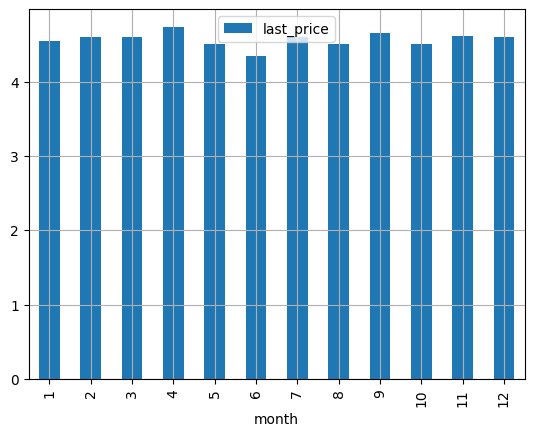

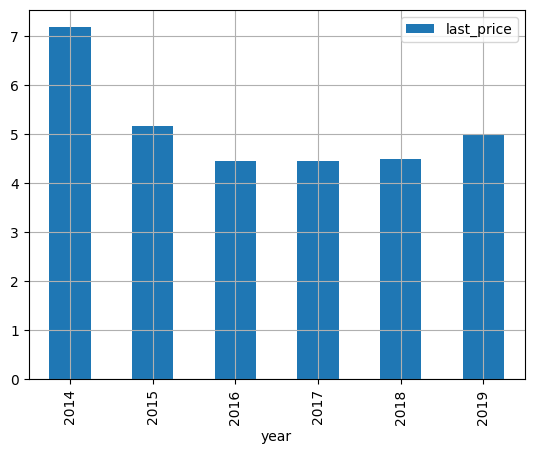

In [57]:
for i in ['floor_type', 'dow', 'month', 'year']: # Медиана цены в зависимости от списка параметров. Миллионов.
    (ds.pivot_table(index=i, values='last_price', aggfunc='median')/1000000).plot.bar(grid=True)

**Промежуточный вывод**: Имеется отчётливая зависимость цены от площади жилья. Чем у объекта больше общая площадь, жилая площадь, площадь кухни и количество комнат - тем дороже он будет. 

Жильё на первом этаже в целом стоит меньше всех остальных. На последнем этаже ненамного больше. Дороже всех категория 'Другой', люди определенно предпочитают их. 

Цена на жильё падала с 2014 по 2016 год. После, по 2018 год цены не сильно менялись. В 2019 цена показала незначительный рост. Зависимость определённо имеется.

Месяц и день выкладывания объявления никак не влияют на стоимость объекта. 

### Расчёт средней цены квадратного метра

Теперь мы отберём из всех записей 10 самых популярных населённых пунктов, посчитаем среднюю цену квадратного метра жилья, и определим в каких населённых пунктах самый дешёвый квадратный метр, а в каких самый дорогой.

<AxesSubplot:ylabel='locality_name'>

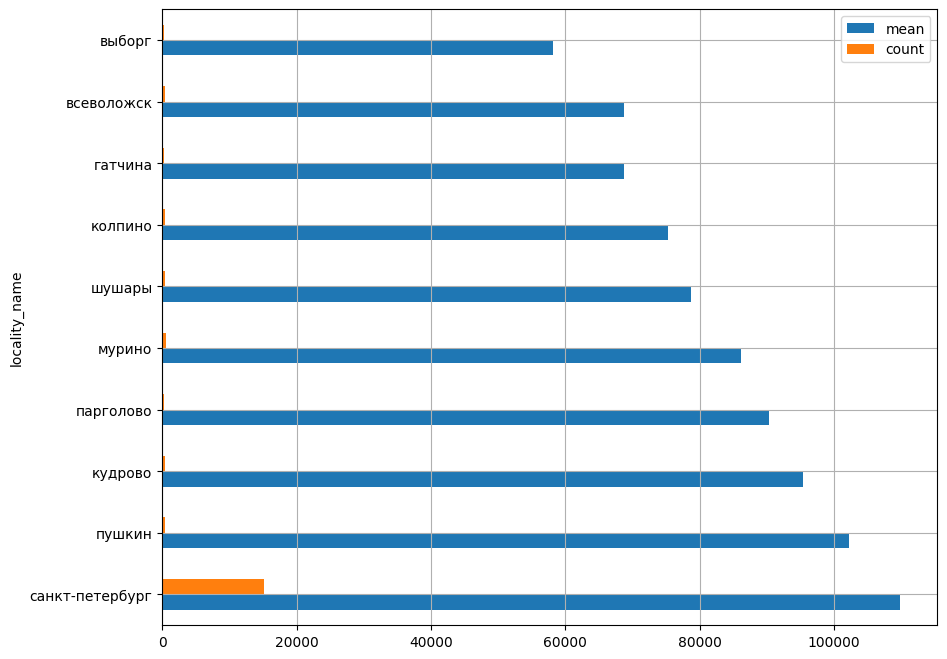

In [58]:
square_pivot = ds.pivot_table(index='locality_name', values='square_price', aggfunc=['mean', 'count']) # Сводная таблица с подсчётом средней цены и общего кол-ва объявлений для каждого города
square_pivot.columns = ['mean', 'count'] # Переименование столбцов
square_pivot = square_pivot.sort_values(by = 'count', ascending=False).head(10) # Сортировка по количеству, сохранение десяти записей с наибольшим значением
square_pivot.sort_values(by='mean', ascending=False).plot(kind='barh', grid=True, figsize=(10, 8)) # Сортировка по средней цене и формирование графика

**Промежуточный вывод**: Самый дорогой город для проживания, он-же самый густонаселённый - Санкт-Петербург. Следом за ним идут города Пушкин и Кудрово. Самую низкую цену квадратного метра жилья показал город Выборг.

### Расчёт зависимости цены от расстояния до центра в Санкт-Петербурге

Теперь мы посчитаем среднюю цену для каждого километра удалённости от центра города Санкт-Петербурга. Разумеется в выборку войдут только дома, находящиеся в этом-же городе.

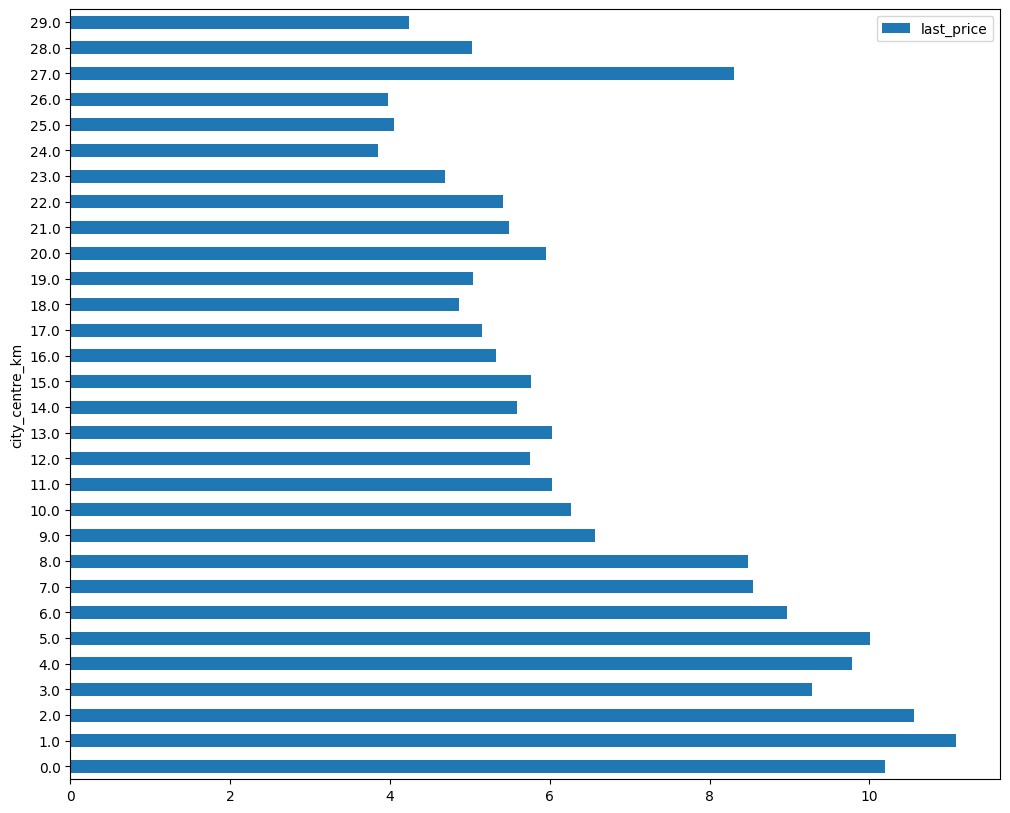

In [59]:
(ds[ds['locality_name'] == 'санкт-петербург'].pivot_table(index='city_centre_km', values='last_price')/1000000).plot(kind='barh', figsize=(12, 10)); # Построение графика по сводной таблице со средними значениями цены по километрам для Санкт-Петербурга
# Средняя цена, миллионов

**Промежуточный вывод**: Чем ближе к центру - тем дороже становится жильё. Но эта тенденция проявляется только на ближайших восьми километрах. От девяти и более километров стоимость жилья сохраняет сравнительную стабильность. Всплекс на 27 километре может быть связан с расположением загородного элитного жилья, или чего-то похожего.

## Общий вывод

**Предобработка**

В рамках предобработки было выполнено следующее:
- Заполнены пропуски медианными значениями в данных о высоте потолков, жилой площади и количестве этажей
- Удалены пропуски в булевом столбце апартаментов и количестве балконов, из расчёта что пропуски равны отрицательному ответу.
- Заполнены пропуски в информации о площади кухни. Студии и квартиры с незначительной разницей между жилой площадью и общей площадью помечены как не имеющие собственной кухни, остальным значениям присвоена медиана.
- Столбец с датами объявлений переведён из строки в соответствующий тип datetime, количеству балконов присвоен целочисленный тип данных
- Удалены дублирующие названия населённых пунктов, все названия приведены к нижнему регистру.
- Обработаны аномальные значения высоты потолков.
- Добавлены новые столбцы с преобразованными данными для более удобного доступа при исследовании.

**Исследование**

В рамках самого исследования был произведён:
- Анализ гистограмм основных параметров. В результате были выявлены и удалены 2 аномальные записи о количестве этажей. Все остальные данные показали ожидаемый результат.
- Анализ скорости продажи квартир. Графики показали плавное снижение количества продаж с течением времени. Абсолютное большинство всех продаж совершается в диапазоне от 45 до 230 дней. Всё выходящее за него можно считать быстрыми или очень долгими продажами соответственно.
- Анализ влияния различных факторов на цену объекта. Прослеживается явная зависимость цены от площади жилья и количества комнат, также имеется определённая завимость от года выкладывания объявления и этажа квартиры(Цена больше у квартир, расположенных не на первом и не на последнем этаже)
- Анализ средних цен за квадратный метр жилья. Самый дорогой средний квадратный метр в Санкт-Петербурге, а самый дешёвый в Выборге.
- Анализ зависимости цены от расстояния до центра в городе Санкт-Петербурге. График показал плавное снижение цен с увеличением удалённости жилья от центра, вплоть до восьми километров. Цены на жильё на расстоянии девяти и более километров остаются стабильными.

**Рекомендации заказчику**:

1. Определить точную причину возникновения пропущенных значений в заполняемых вручную данных. При необходимости сделать поля обязательными к заполнению, или ввести стандартное значение(Если пользователь не ввёл количество балконов - устанавливается 0)
2. Определить точную причину возникновения пропущенных значений в автоматически заполняемых данных и исправить пропуски в датасете. При необходимости повторить исследование с дополненными данными, более 50% пропусков могли сильно повлиять на результат исследования.
3. Сравнить показатели Санкт-Петербурга с другими крупными городами и проверить сохраняются-ли тенденции распределения стоимости жилья. Это поможет определить, существуют-ли индивидуальные особенности субьектов, перед созданием автоматизированной системы.